## Imports

In [1]:
import os
import torch
import torch.nn as nn
import wandb
import numpy as np

from torchvision import transforms
from dataset.transforms import transform
from model.mmcv_csn import ResNet3dCSN
from model.cls_head import ClassifierHead
from model.pose_encoder import PoseEncoder
from model.scheduler import GradualWarmupScheduler
from model.multimodal_neck import MultiModalNeck
from mmaction.datasets import build_dataset
from dataset.dataset import MultiModalDataset
from dataset.transforms import transform
from torch.utils.data import DataLoader

/home/sadat/miniconda3/envs/dataloader/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sadat/miniconda3/envs/dataloader/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
# wandb.init(entity="cares", project="seven-sees",
#            group="v1")

wandb: Currently logged in as: sttaseen (cares). Use `wandb login --relogin` to force relogin


In [2]:
device='cuda'

In [3]:
work_dir = 'work_dirs/wlasl-dataset/'
batch_size = 1

os.makedirs(work_dir, exist_ok=True)

In [4]:
transforms_train = transform(mode = 'train')
transforms_test = transform(mode = 'test')

train_dataset = MultiModalDataset(ann_file='data/wlasl10/train_annotations.txt',
                            root_dir='data/wlasl10/rawframes',
                            clip_len=32,#
                            resolution=224,
                            transforms = transforms_train,
                            frame_interval=1,
                            num_clips=1
                            )

test_dataset = MultiModalDataset(ann_file='data/wlasl10/test_annotations.txt',
                            root_dir='data/wlasl10/rawframes',
                            clip_len=32,
                            resolution=224,
                            transforms = transforms_test,
                            frame_interval=1,
                            num_clips=1
                            )

# Setting up dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    num_workers=1,
                                    pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                    batch_size=1,
                                    shuffle=True,
                                    num_workers=1,
                                    pin_memory=True)


In [5]:
rgb, _, face, left_hand, right_hand, depth, flow, pose,  label = next(iter(train_loader)) 

In [6]:
rgb.shape

torch.Size([1, 3, 32, 224, 224])

In [7]:
import matplotlib.pyplot as plt

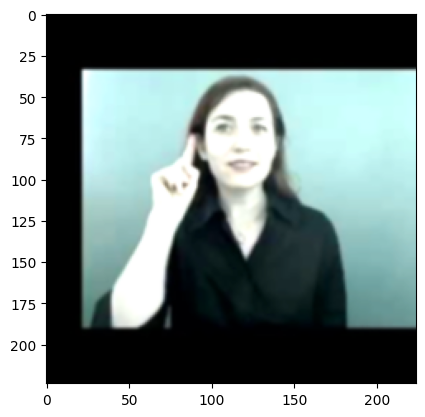

In [8]:
plt.imshow(rgb.permute(0,2,3,4,1)[0][10].cpu().numpy())

In [7]:
from model.seven_seas_net import SevenSeesNet

model = SevenSeesNet()
model.init_weights()

2023-02-12 14:43:03,574 - model - INFO - load model from: https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r50_ig65m_20210617-ce545a37.pth
2023-02-12 14:43:03,575 - model - INFO - load checkpoint from http path: https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r50_ig65m_20210617-ce545a37.pth
2023-02-12 14:43:03,612 - model - INFO - load model from: https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r50_ig65m_20210617-ce545a37.pth
2023-02-12 14:43:03,613 - model - INFO - load checkpoint from http path: https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r50_ig65m_20210617-ce545a37.pth
2023-02-12 14:43:03,645 - model - INFO - load model from: https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r50_ig65m_20210617-ce545a37.pth
2023-02-12 14:43:03,646 - model - INFO - load checkpoint from http path: https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scrat

## Training Loop

In [8]:
# Specify optimizer
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.000125, momentum=0.9, weight_decay=0.00001)

# Specify Loss
loss_cls = nn.CrossEntropyLoss()

# Specify total epochs
epochs = 100

# Specify learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=120, gamma=0.1)

scheduler_steplr = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[34, 84], gamma=0.1)
scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=16, after_scheduler=scheduler_steplr)

# Specify Loss
loss_fn = nn.CrossEntropyLoss()

# Setup wandb
wandb.watch(model, log_freq=10)

[]

In [11]:
def top_k_accuracy(scores, labels, topk=(1, )):
    """Calculate top k accuracy score.
    Args:
        scores (list[np.ndarray]): Prediction scores for each class.
        labels (list[int]): Ground truth labels.
        topk (tuple[int]): K value for top_k_accuracy. Default: (1, ).
    Returns:
        list[float]: Top k accuracy score for each k.
    """
    res = np.zeros(len(topk))
    labels = np.array(labels)[:, np.newaxis]
    for i, k in enumerate(topk):
        max_k_preds = np.argsort(scores, axis=1)[:, -k:][:, ::-1]
        match_array = np.logical_or.reduce(max_k_preds == labels, axis=1)
        topk_acc_score = match_array.sum() / match_array.shape[0]
        res[i] = topk_acc_score

    return res


def train_one_epoch(epoch_index, interval=5):
    """Run one epoch for training.
    Args:
        epoch_index (int): Current epoch.
        interval (int): Frequency at which to print logs.
    Returns:
        last_loss (float): Loss value for the last batch.
    """
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, (rgb, _, face, left_hand, right_hand, depth, flow, pose, targets) in enumerate(train_loader):
        rgb, face, left_hand, right_hand, depth, flow, pose, targets = rgb.to(device), face.to(device),left_hand.to(device), right_hand.to(device), depth.to(device), flow.to(device), pose.to(device), targets.to(device)
#         rgb = rgb.reshape((-1, ) + rgb.shape[2:])
#         face = face.reshape((-1, ) + face.shape[2:])
#         flow = flow.reshape((-1, ) + flow.shape[2:])
#         left_hand = left_hand.reshape((-1, ) + left_hand.shape[2:])
#         right_hand = right_hand.reshape((-1, ) + right_hand.shape[2:])
#         depth = depth.reshape((-1, ) + depth.shape[2:])
        
        targets = targets.reshape(-1, )

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(rgb=rgb,
                         depth=depth,
                         flow=flow,
                         face=face,
                         left_hand=left_hand,
                         right_hand=right_hand,
                         pose=pose)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, targets)
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), max_norm=40, norm_type=2.0)

        # Adjust learning weights
        optimizer.step()
        

        # Gather data and report
        running_loss += loss.item()
        if i % interval == interval-1:
            last_loss = running_loss / interval  # loss per batch
            print(
                f'Epoch [{epoch_index}][{i+1}/{len(train_loader)}], lr: {scheduler.get_last_lr()[0]:.5e}, loss: {last_loss:.5}')
            running_loss = 0.

    return last_loss, scheduler.get_last_lr()[0]


def validate():
    """Run one epoch for validation.
    Returns:
        avg_vloss (float): Validation loss value for the last batch.
        top1_acc (float): Top-1 accuracy in decimal.
        top5_acc (float): Top-5 accuracy in decimal.
    """
    running_vloss = 0.0
    running_vacc = np.zeros(2)

    print('Evaluating top_k_accuracy...')

    with torch.inference_mode():
        for i, (rgb, _, face, left_hand, right_hand, depth, flow, pose, targets)  in enumerate(test_loader):
            rgb, face, left_hand, right_hand, depth, flow, pose, targets = rgb.to(device), face.to(device), left_hand.to(device), right_hand.to(device), depth.to(device), flow.to(device), pose.to(device), targets.to(device)
            
            targets = targets.reshape(-1, )

            outputs = model(rgb=rgb,
                             depth=depth,
                             flow=flow,
                             face=face,
                             left_hand=left_hand,
                             right_hand=right_hand,
                             pose=pose)

            loss = loss_fn(outputs, targets)
            running_vloss += loss

            running_vacc += top_k_accuracy(outputs.detach().cpu().numpy(),
                                           targets.detach().cpu().numpy(), topk=(1, 5))

    avg_vloss = running_vloss / (i + 1)

    acc = running_vacc/len(test_loader)
    top1_acc = acc[0].item()
    top5_acc = acc[1].item()

    return (avg_vloss, top1_acc, top5_acc)

In [12]:
# Train Loop
best_vloss = 1_000_000.

# Transfer model to device
model.to(device)

for epoch in range(epochs):
    # Turn on gradient tracking and do a forward pass
    model.train(True)
    avg_loss, learning_rate = train_one_epoch(epoch+1)

    # Turn off  gradients for reporting
    model.train(False)

    avg_vloss, top1_acc, top5_acc = validate()

    print(
        f'top1_acc: {top1_acc:.4}, top5_acc: {top5_acc:.4}, train_loss: {avg_loss:.5}, val_loss: {avg_vloss:.5}')

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = work_dir + f'epoch_{epoch+1}.pth'
        print(f'Saving checkpoint at {epoch+1} epochs...')
        torch.save(model.state_dict(), model_path)

     # Adjust learning rate
    scheduler.step()
    
    # Track wandb
    wandb.log({'train/loss': avg_loss,
               'train/learning_rate': learning_rate,
               'val/loss': avg_vloss,
               'val/top1_accuracy': top1_acc,
               'val/top5_accuracy': top5_acc})

KeyboardInterrupt: 